In [37]:
from vsm import *
from vsm.spatial import *

In [38]:
path = '/var/inphosemantics/data/20140801/sep/vsm-data/'
c = Corpus.load(path + 'sep-nltk-freq1.npz')
lda_m = dict()
lda_v = dict()


for k in range(20,100,20):
    lda_m[k] = LdaCgsSeq.load(path + 'sep-nltk-freq1-article-LDA-K%s.npz' % k)
    lda_v[k] = LdaCgsViewer(c,lda_m[k])

articles = c.view_metadata('article')['article_label']


Loading LDA data from /var/inphosemantics/data/20140801/sep/vsm-data/sep-nltk-freq1-article-LDA-K20.npz
Loading LDA data from

 /var/inphosemantics/data/20140801/sep/vsm-data/sep-nltk-freq1-article-LDA-K40.npz
Loading LDA data from

 /var/inphosemantics/data/20140801/sep/vsm-data/sep-nltk-freq1-article-LDA-K60.npz
Loading LDA data from

 /var/inphosemantics/data/20140801/sep/vsm-data/sep-nltk-freq1-article-LDA-K80.npz


In [39]:
tops = np.array(lda_v[40].topics())
lda_v[40].topics(topic_indices=[36,15])
tops[(36,15),:]

array([[('one', 0.02780887799348529), ('would', 0.013034225254337388),
        ('way', 0.010242222294379995), ...,
        ('dimension', 1.822456240174229e-08),
        ('semantics', 1.822456240174229e-08),
        ('game', 1.822456240174229e-08)],
       [('one', 0.030757954929507808), ('would', 0.01159863746769285),
        ('way', 0.009523906678718922), ...,
        ('probability', 2.028084837699066e-08),
        ('williams', 2.028084837696184e-08),
        ('norms', 2.028084837693302e-08)]], 
      dtype=[('word', 'S96'), ('value', '<f8')])

In [40]:
import itertools
import brewer2mpl as brewer

def brew(N, n_cls, reverse=True):
    b = [
        brewer.get_map('Blues', 'Sequential', N+1, reverse=reverse).mpl_colors[:N],
        brewer.get_map('Oranges', 'Sequential', N+1, reverse=reverse).mpl_colors[:N],
        brewer.get_map('Greens', 'Sequential', N+1, reverse=reverse).mpl_colors[:N],
        brewer.get_map('Purples', 'Sequential', N+1, reverse=reverse).mpl_colors[:N],
        brewer.get_map('Greys', 'Sequential', N+1, reverse=reverse).mpl_colors[:N],
        brewer.get_map('Reds', 'Sequential', N+1, reverse=reverse).mpl_colors[:N]
    ]
    return b[:n_cls]

def get_topic_colors(v):
    data = v.topic_oscillations()
    
    colors = [itertools.cycle(cs) for cs in zip(*brew(3,n_cls=4))]
    factor = len(data) / len(colors)
    
    topic_colors =  [(topic_datum[0], colors[min(rank / factor, len(colors)-1)].next()) 
                 for rank, topic_datum in enumerate(data)]
    topic_colors.sort(key=lambda x: x[0])
    return topic_colors

0.810866629466


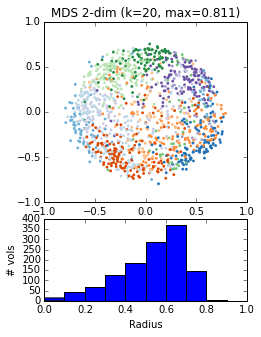

In [59]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

n2 = dict(); n3 = dict();
bins2 = dict(); bins3 = dict();
patches2 = dict(); patches3 = dict();
pos2 = dict(); pos3 = dict();

for k in range(20,40,20):
    tops = lda_v[k].doc_topics(articles)
    tops = [tops[t][tops[t].argsort(axis=0)]['value'] for t in xrange(len(tops))]
    #tops = [numpy.random.dirichlet([0.01 for t in range(k)]) for d in range(len(articles))]
    #colors= [i[1] for i in get_topic_colors(lda_v[k])]

    
    similarities = euclidean_distances(tops)
    similarities = JS_dist(np.array(tops), np.array(tops).T)
    similarities = np.nan_to_num(similarities)
    
    seed = np.random.RandomState(seed=2)
    mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                       dissimilarity="precomputed", n_jobs=1)
    pos = mds.fit(similarities).embedding_
    pos *= np.sqrt((np.array(tops) ** 2).sum()) / np.sqrt((pos ** 2).sum())

    clf = PCA(n_components=2)
    X_true = clf.fit_transform(similarities)
    pos = clf.fit_transform(pos)
    pos2[k] = pos

    radii = np.sqrt(pos[:,0]**2 + pos[:,1]**2)
    print radii.max()

    fig = plt.figure(figsize=(8,5))
    ax1 = plt.subplot2grid((3,2), (0,0), rowspan=2)
    ax1.scatter(pos[:, 0], pos[:, 1], 
                c=[colors[top.argmax()] for top in tops], s=8, edgecolor='none')
    ((xmin,xmax), (ymin,ymax)) = plt.xlim(), plt.ylim()


    ax2 = plt.subplot2grid((3,2), (2,0))
    ax1.set_title("MDS 2-dim (k={k}, max={max:0.3f})".format(k=k, max=radii.max()))
    n2[k], bins2[k], patches2[k] = ax2.hist(radii, bins=np.arange(0,1.01,0.1))
    ax2.set_xlim(0,1.0)
    ax2.set_xlabel("Radius")
    ax2.set_ylabel("# vols")
    """
    #3D
    seed = np.random.RandomState(seed=2)
    mds = manifold.MDS(n_components=3, max_iter=300, eps=1e-9, random_state=seed,
                       dissimilarity="precomputed", n_jobs=1)
    pos = mds.fit(similarities).embedding_
    pos *= np.sqrt((np.array(tops) ** 2).sum()) / np.sqrt((pos ** 2).sum())

    clf = PCA(n_components=3)
    X_true = clf.fit_transform(similarities)
    pos = clf.fit_transform(pos)
    pos3[k] = pos
    
    radii = np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)
    print radii.max()

    ax3 = plt.subplot2grid((3,2), (0,1), rowspan=2, projection='3d')
    ax3.scatter3D(pos[:, 0], pos[:, 1], pos[:,2],
                  c=[colors[top.argmax()] for top in tops], s=8, edgecolor='none')

    ax4 = plt.subplot2grid((3,2), (2,1))
    n3[k], bins3[k], patches3[k] = ax4.hist(radii, bins=np.arange(0,1.01,0.1))
    ax4.set_xlim(0,1.0)
    ax4.set_xlabel("Radius")
    ax4.set_ylabel("# vols")
    ax3.set_title("MDS 3-dim (k={k}, max={max:0.3f})".format(k=k, max=radii.max()))
    """
    #fig.subplots_adjust(top=1.5)
    plt.show()

10


KeyError: 40

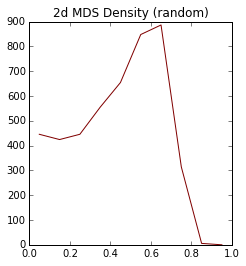

In [43]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title("2d MDS Density (random)")
for j,k in enumerate(range(20,100,20)):
    bin_mid = [(bins2[k][i]+bins2[k][i+1])/2 for i in range(len(bins2[k])-1)]
    bins = np.array(bins2[k])
    area = (bins[1:]**2 - bins[:-1]**2) * np.pi
    print len(area)
    plot(bin_mid, n2[k] / area,# drawstyle='steps-mid',
         color=plt.cm.jet_r(j/4.1), label='k={k}'.format(k=k))
plt.ylabel("N / Area")
plt.xlabel("Radius")
    
plt.subplot(122)
plt.title("3d MDS Density (random)")
for j,k in enumerate(range(20,100,20)):
    bin_mid = [(bins3[k][i]+bins3[k][i+1])/2 for i in range(len(bins3[k])-1)]
    bins = np.array(bins3[k])
    area = (bins[1:]**3 - bins[:-1]**3) * np.pi * 4/3
    plot(bin_mid, n3[k] / (np.array(bins3[k][1:])**2),# drawstyle='steps-mid',
         color=plt.cm.jet_r(j/4.1), label='k={k}'.format(k=k))
plt.legend(loc='upper left')
plt.ylabel(r"N / Volume")
plt.xlabel("Radius")

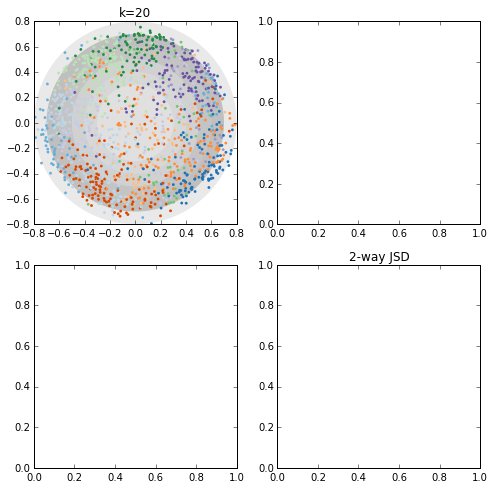

In [60]:
f, ((ax1, ax2), (ax3, ax4)) = pylab.subplots(2, 2, figsize=(8,8))
pylab.title("2-way JSD")
axes = [ax1,ax2,ax3,ax4]

ns = np.array([n2[k] for k in range(20,40,20)])
areas = [(bins2[k][1:]**2 - bins2[k][:-1]**2) * np.pi for k in range(20,40,20)]
max_all = (ns/areas).flatten().max()

def donut(ax,n, radii, max=388):
    theta = np.linspace(0, 2*np.pi, 100, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))

    # in order to have a closed area, the circles
    # should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]

    ax.fill(np.ravel(xs), np.ravel(ys), facecolor='k', alpha=0.25*n/float(max), edgecolor='none',zorder=0)
    #facecolor='#348ABD'
    
def logical_all(*args):
    so_far = np.array(args[0])
    for arg in args[1:]:
        so_far = np.logical_and(so_far, np.array(arg))
    return so_far

for k, axis in zip(range(20,40,20), axes):
    #fig = plt.figure(figsize=(8,6))
    bins = np.array(bins2[k])
    area = (bins[1:]**2 - bins[:-1]**2) * np.pi
    
    tops = lda_v[k].doc_topics(articles)
    tops = [tops[t][tops[t].argsort(axis=0)]['value'] for t in xrange(len(tops))]
    colors= [i[1] for i in get_topic_colors(lda_v[k])]
    
    for i in range(len(n2[k])):
        donut(axis, n2[k][i]/area[i], [bins2[k][i], bins2[k][i+1]], max=max_all)

    axis.scatter(pos2[k][:, 0], pos2[k][:, 1], 
                 c=[colors[top.argmax()] for top in tops], s=8, edgecolor='none')
    ((xmin,xmax), (ymin,ymax)) = plt.xlim(), plt.ylim()

    axis.set_xlim(-0.8,0.8)
    axis.set_ylim(-0.8,0.8)
    axis.set_title("k={k}".format(k=k))

In [61]:
theta = np.linspace(0, 2*np.pi, 100, endpoint=True)
xs = np.outer([2.,3.], np.cos(theta))
ys = np.outer([2.,3.], np.sin(theta))

xs[1,:] = xs[1,::-1]
ys[1,:] = ys[1,::-1]

In [62]:
xs = pos[:,0]
ys = pos[:,1]
r = np.sqrt(xs**2 + ys**2)
phi = np.arctan2(xs, ys)
[np.logical_and(r > 0.4, phi > 0)]

[array([False, False, False, ..., False, False,  True], dtype=bool)]

In [63]:
pos[np.logical_and(r > 0.4, phi > 0)]

array([[ 0.16077007, -0.56898738],
       [ 0.12563722,  0.45197707],
       [ 0.53772906, -0.34122706],
       [ 0.3677362 ,  0.59866415],
       [ 0.50123665, -0.42887743],
       [ 0.59692324, -0.4394789 ],
       [ 0.32685002, -0.59492749],
       [ 0.64118127,  0.12674495],
       [ 0.06251665, -0.55699798],
       [ 0.02958413,  0.48069494],
       [ 0.29670478,  0.65440481],
       [ 0.01758659, -0.59752015],
       [ 0.32175958,  0.54856237],
       [ 0.0261906 , -0.44722997],
       [ 0.07617037, -0.61097201],
       [ 0.10476931, -0.51324327],
       [ 0.22283114, -0.52365246],
       [ 0.03859276, -0.67276434],
       [ 0.4666625 ,  0.35784131],
       [ 0.41962383,  0.35510209],
       [ 0.02381469, -0.47185146],
       [ 0.20597368, -0.48277754],
       [ 0.66435295, -0.35913935],
       [ 0.21774786,  0.37533883],
       [ 0.29259541,  0.42952767],
       [ 0.6663249 , -0.09790372],
       [ 0.26530986,  0.4612457 ],
       [ 0.3756719 ,  0.22543104],
       [ 0.47159161,

In [73]:
from collections import defaultdict

maxes = defaultdict(list)
for k in range(20,40,20):
    tops = lda_v[k].doc_topics(articles)
    tops = [tops[t][tops[t].argsort(axis=0)]['value'] for t in xrange(len(tops))]
    
    xs = pos2[k][:,0]
    ys = pos2[k][:,1]
    r = np.sqrt(xs**2 + ys**2)
    phi = np.arctan2(xs, ys)

    show_results= False
    for i in np.arange(-1.,1.,1/32.)*np.pi:
        cond = logical_all(r >= 0.4, i < phi, i + (1/32.*np.pi) > phi)
        counts = np.bincount([top.argmax() for top in np.array(tops)[cond]])
        
        if np.any(counts):
            if counts.argmax() not in maxes[k]:
                maxes[k].append(counts.argmax())
            if show_results:
                print i, counts.argmax(), counts[counts.argmax()] / float(len(np.array(tops)[cond]))
    print len(maxes[k])
    """
    for i in np.arange(-1.,1.,1/32.)*np.pi:
        cond = logical_all(r <= 0.4, i < phi, i + (1/32.*np.pi) > phi)
        counts = np.bincount([top.argmax() for top in np.array(tops)[cond]])
        
        if np.any(counts):
            if counts.argmax() not in maxes[k]:
                maxes[k].append(counts.argmax())
            if show_results:
                print i, counts.argmax(), counts[counts.argmax()] / float(len(np.array(tops)[cond]))
    """

18


In [74]:
lda_v[20].topics(topic_indices=maxes[20][:])

[LabeledColumn([('aristotle', 0.023834336084230853), ('plato', 0.01870616411337366),
        ('socrates', 0.01394564847664467), ...,
        ('mistake', 6.338902312531465e-08),
        ('choice', 6.338902312513448e-08),
        ('tension', 6.338902312513448e-08)], 
       dtype=[('word', 'S96'), ('value', '<f8')]),
 LabeledColumn([('one', 0.013957663586998657), ('objects', 0.012576984977327805),
        ('object', 0.010452274005778773), ...,
        ('strict', 2.556812240121614e-08),
        ('publication', 2.556812240121614e-08),
        ('american', 2.556812240121614e-08)], 
       dtype=[('word', 'S96'), ('value', '<f8')]),
 LabeledColumn([('god', 0.04567865014918908), ('divine', 0.010040833955709852),
        ('human', 0.00831426860326214), ...,
        ('academic', 3.4257249056276303e-08),
        ('significance', 3.4257249056276303e-08),
        ('so-called', 3.4257249056276303e-08)], 
       dtype=[('word', 'S96'), ('value', '<f8')]),
 LabeledColumn([('de', 0.009047881230683312), ('philosophy', 0.008314530506463318),
        ('aristotle', 0.0069430694118181365), ...,
        ('sufficient', 4.762017689722352e-08),
        ('common', 4.762017689722352e-08),
        ('course', 4.7620176897088176e-08)], 
       dtype=[('word', 'S96'), ('value', '<f8')]),
 LabeledColumn([('kant', 0.017201779241319954), ('hume', 0.00856265058179156),
        ('reason', 0.008333116551176443), ...,
        ('epistemology', 3.326580153829797e-08),
        ('fallacy', 3.326580153829797e-08),
        ('self-interest', 3.326580153820342e-08)], 
       dtype=[('word', 'S96'), ('value', '<f8')]),
 LabeledColumn([('philosophy', 0.011474918642932246),
        ('philosophical', 0.006985591982809907),
        ('also', 0.006934688148024393), ...,
        ('reductionism', 1.9578397994354548e-08),
        ('unclear', 1.9578397994354548e-08),
        ('worry', 1.9578397994326725e-08)], 
       dtype=[('word', 'S96'), ('value', '<f8')]),
 LabeledColumn([('art', 0.01159298754449686), ('world', 0.008071950417397961),
        ('philosophy', 0.005794698804814946), ...,
        ('applied', 3.6261968353096696e-08),
        ('available', 3.6261968353096696e-08),
        ('treated', 3.6261968353045166e-08)], 
       dtype=[('word', 'S96'), ('value', '<f8')]),
 LabeledColumn([('women', 0.020233744243396478), ('social', 0.016081593322104234),
        ('feminist', 0.009842654476488645), ...,
        ('genes', 4.2849854708737524e-08),
        ('claimed', 4.2849854708737524e-08),
        ('dangerous', 4.2849854708737524e-08)], 
       dtype=[('word', 'S96'), ('value', '<f8')]),
 LabeledColumn([('law', 0.015992264931342925), ('political', 0.015083650516229619),
        ('rights', 0.012345402978533199), ...,
        ('entail', 3.101073089112281e-08),
        ('whereas', 3.101073089112281e-08), ('key', 3.101073089103467e-08)], 
       dtype=[('word', 'S96'), ('value', '<f8')]),
 LabeledColumn([('moral', 0.025023930458817064), ('one', 0.015891938912579163),
        ('good', 0.01125093704873136), ...,
        ('evident', 2.3439403352678746e-08),
        ('took', 2.3439403352612125e-08), ('belong', 2.3439403352612125e-08)], 
       dtype=[('word', 'S96'), ('value', '<f8')]),
 LabeledColumn([('one', 0.019111061643332837), ('would', 0.011094291688582327),
        ('argument', 0.009183618590967705), ...,
        ('omniscience', 1.4387598626562155e-08),
        ('reports', 1.4387598626521264e-08), ('k', 1.4387598626521264e-08)], 
       dtype=[('word', 'S96'), ('value', '<f8')]),
 LabeledColumn([('true', 0.011566092315890621), ('x', 0.010820725234942477),
        ('identity', 0.009895441962041328), ...,
        ('neumann', 5.14046262720201e-08),
        ('anything', 5.140462627194705e-08),
        ('allows', 5.140462627194705e-08)], 
       dtype=[('word', 'S96'), ('value', '<f8')]),
 LabeledColumn([('logic', 0.03183723522133191), ('language', 0.012755829179738968),
        ('truth', 0.012464300058895946), ...,
        ('subjectively', 5.5005494498476104e-08),
        ('go', 5.5005

In [75]:
lda_v[20].topics(topic_indices=[i for i in np.arange(0,20) if i not in maxes[20]])

[LabeledColumn([('science', 0.0283421774429161),
        ('scientific', 0.019508195424365632),
        ('theory', 0.018292877975999183), ...,
        ('needed', 5.7326294734051445e-08),
        ('generally', 5.7326294734010715e-08),
        ('come', 5.7326294734010715e-08)], 
       dtype=[('word', 'S96'), ('value', '<f8')]),
 LabeledColumn([('belief', 0.01892164133787228), ('p', 0.018359712336061623),
        ('knowledge', 0.017812701803325587), ...,
        ('share', 4.972823024847347e-08), ('entry', 4.97282302484028e-08),
        ('contents', 4.97282302484028e-08)], 
       dtype=[('word', 'S96'), ('value', '<f8')])]

In [ ]:
lda_v[40].topics(topic_indices=maxes[40])

In [ ]:
lda_v[40].topics(topic_indices=[i for i in np.arange(0,40) if i not in maxes[40]])

In [ ]:
lda_v[60].topics(topic_indices=maxes[60])

In [ ]:
lda_v[80].topics(topic_indices=maxes[80])

In [ ]:
v=lda_v[80]

In [ ]:
v.model.alpha.shape

In [ ]:
v.model.V

In [ ]:
v=lda_v[20]
np.mean(v.theta.sum(axis=1)

In [ ]:
np.sum(v.model.top_doc / len(v.corpus.corpus), axis=1)

In [ ]:
help(v)

In [ ]:
sum(v.phi[:,1])

In [ ]:
xs = np.array(articles)[(pos2[20][:, 0]).argsort()]

print "Low x"
for x in xs[:10]:
    print "*", x
print "\nHigh x"
for x in xs[-10:]:
    print "*", x

In [ ]:
xs = np.array(articles)[(pos2[20][:, 1]).argsort()]

print "Low y"
for x in xs[:10]:
    print "*", x
print "\nHigh y"
for x in xs[-10:]:
    print "*", x

In [ ]:
len(pos2[20])